In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = 'Users\zacks\Documents\dspt7-predictive-modeling-challenge'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(r'C:\Users\zacks\Documents\dspt7-predictive-modeling-challenge\train_features.csv'), 
                 pd.read_csv(r'C:\Users\zacks\Documents\dspt7-predictive-modeling-challenge\train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(r'C:\Users\zacks\Documents\dspt7-predictive-modeling-challenge\test_features.csv')
sample_submission = pd.read_csv(r'C:\Users\zacks\Documents\dspt7-predictive-modeling-challenge\sample_submission.csv')

In [3]:
import numpy as np
def wrangle(df):
  df = df.copy()

  #getting rid of close to zeros in the latitude
  df['latitude'] = df['latitude'].replace(-2e-08, 0)

  #replacing zeros in columns with nan so they can be imputed later
  zero_cols = ['longitude', 'latitude', 'construction_year', 'gps_height', 'population']
  for col in zero_cols:
    df[col] = df[col].replace(0, np.nan)
    df[col+'_missing'] = df[col].isnull()

  #getting rid of columns that don't give me any real information
  duplicates = ['quantity_group', 'payment_type']
  df = df.drop(columns=duplicates)

  unusable_variance = ['recorded_by', 'id']
  df = df.drop(columns=unusable_variance)

  #getting the time recorded into datetime then splitting into components 
  df['date_recorded'] = pd.to_datetime(df['date_recorded'], infer_datetime_format=True)

  df['year_recorded'] = df['date_recorded'].dt.year
  df['month_recorded'] = df['date_recorded'].dt.month
  df['day_recorded'] = df['date_recorded'].dt.day
  df = df.drop(columns='date_recorded')

  #How many years since the pump was constructed
  df['years'] = df['year_recorded'] - df['construction_year']
  df['years_missing'] = df['years'].isnull()

  return df

train = wrangle(train)
test = wrangle(test)

In [4]:
#running my pipeline and cross validation to tune hyper parameters
#imports 
from category_encoders.ordinal import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint


In [15]:

target = 'status_group'
train_features = train.drop(columns=target)
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
features = numeric_features + categorical_features
X_train = train[features]
y_train = train[target]
X_test = test[features]
pipeline = make_pipeline(
    OrdinalEncoder(cols=categorical_features), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=42, n_jobs= -1)
)

param_distributions = {   
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__class_weight': ['balanced', None],
    'randomforestclassifier__max_depth': [5,10,15,20, None],
    'randomforestclassifier__n_estimators': randint(50,500),
    'randomforestclassifier__min_samples_leaf' : [None, 5,10,15,30],
    'randomforestclassifier__max_features': [None, 2,10,20,30]
}

In [6]:

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)



In [7]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 10.3min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 10.8min remaining:   41.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['basin',
                                                                   'region',
                                                                   'public_meeting',
                                                                   'scheme_management',
                                                                   'permit',
                                                                   'extraction_type',
                                                                   'extraction_type_group',
                                                                   'extraction_type_class',
                                                                   'management',
                                                                   'management_group',
  

In [13]:
search.best_score_

0.7954882154882155

In [19]:
pipeline2 = search 

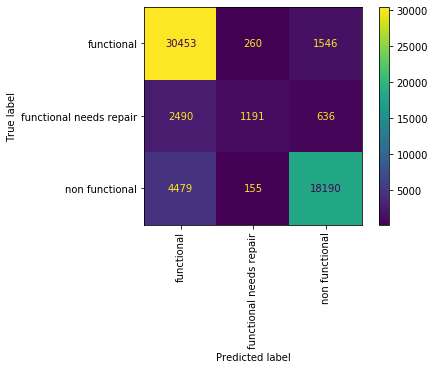

In [23]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline2, X_train, y_train, values_format='.0f', xticks_rotation='vertical')